<a href="https://colab.research.google.com/github/Jandhayalasaikiran/codespaces-jupyter/blob/main/Neural_Machine_Translator_English_French.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural languages are complicated. A word in one language can be translated into multiple words in another, depending on the context.Transformer is a recent breakthrough in neural machine translation.

> Transformer brings this to one level higher so that we can build a neural network for natural language translation using only the attention mechanism but no recurrent Neural Network.



# FLOWWORK OF PROJECT

> Mainsteps involved in project:-

 1. Obtaining Data
 2. Text Normalization
 3. Vectorization and Making Datasets
 4. Positional Encoding Matrix
 5. Positional Encoding Layer
 6. Transformer Building Blocks
 7.Transformer Encoder and Decoder
 8. Building a Transformer
 9.Preparing the Transformer Model for Training
 10.Training the Transformer
 11.Inference from the Transformer Model
 12. Improving the Model






# Obtaining data:

>    I download some data files at https://ankiweb.net/shared/decks/french. The data file would be a ZIP file containing a SQLite database file, from which you can extract the English-French sentence pairs.

However, I may find it more convenient to have a text file version, which you can find it at https://www.manythings.org/anki/. Google hosts a mirror of this file.



In [58]:

import pathlib    # path libary

import tensorflow as tf

# download dataset : https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
# show where the file is located now
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)
# open the file extracted

/root/.keras/datasets/fra.txt


# Text Normalization


> French letters have accents which would be represented as Unicode characters, but such representation is not unique in Unicode.  Just Make convert string into NFKC (compatibility and composition normal form).

Also, convert everything into lowercase in the expectation that this will reduce the number of distinct words in the vocabulary.







In [59]:

import pathlib      # for access path libary
import pickle       # process of converting a python objects into bytestream and store it in a file/database,maintain program across session # serializing or deserailizing
import random
import re           # regular expression
import unicodedata   # unicodedata to convert a Unicode string into NFKC normal form
import tensorflow as tf

# download dataset: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "fra.txt"

def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra

# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

("don't you think we should at least give tom a call ?", "[start] ne penses-tu pas qu'on devrait au moins appeler tom  ?  [end]")
('he made an important discovery .', '[start] il a fait une découverte importante . [end]')
("i'm used to driving on the left .", '[start] je suis habituée à conduire à gauche . [end]')
("i don't care for him .", "[start] lui , je m'en fiche . [end]")
("what's your favorite subject ?", '[start] quel est ta matière préférée  ?  [end]')


For model to know some statistics about dataset. In particularly to see the number of  distinct tokens (words) in each language and how long the sentences and know it.

In [60]:

import pickle
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# count tokens                # for determine no.tokens present in datasets
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs


To known the maximum length of sentences is not as useful as knowing their distribution. and plot a histogram for that. To represent output in histogram plot.  


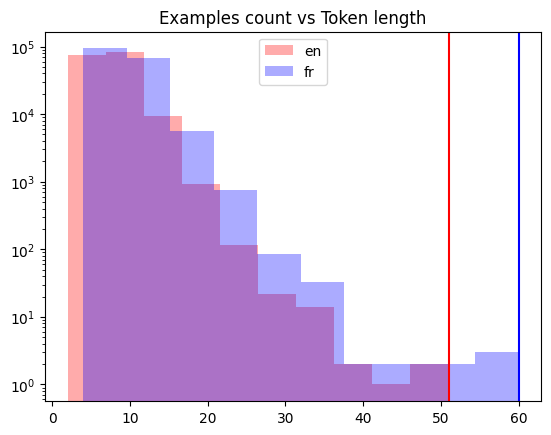

In [61]:
import pickle

import matplotlib.pyplot as plt    # represention plots in stastics

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

# Vectorization and Making Dataset



> Neural networks can handle only numbers. One way to convert the text into numbers is through vectorization.In short it means is to transform the tokens from the text into an integer. Hence a sentence with tokens (words) will become a vector of n integers.


> In neural network tensforflow on top of that Keras, you have TextVectorization layer on building a vectorizer. It supports padding,  integer 0 is reserved to mean “empty.” This is useful when you give a sentence of tokens  want the vectorizer always to return a fixed length
 vector

 The sentence pair into training, validation, and testing sets as you need them for the model training. To need create a TextVectorization layer and adapt it to the training set only


In [62]:

import pickle
import random

from tensorflow.keras.layers import TextVectorization       # text vectorization

# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

# Parameter determined after analyzing the input data
vocab_size_en = 10000       #
vocab_size_fr = 20000
seq_length = 20

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)

# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

The shape should all be (batch size, sequence length)

In [63]:

import pickle

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]

eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

# set up Dataset object
def format_dataset(eng, fra):
    """Take an English and a French sentence pair, convert into input and target.
    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
    is a vector, corresponding to English and French sentences respectively.
    The target is also vector of the French sentence, advanced by 1 token. All
    vector are in the same length.

    The output will be used for training the transformer model. In the model we
    will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
    which should be matched to the keys in the dictionary for the source part
    """
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, fra_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')     # encoding inputs
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')     # decoding outputs
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [ 540 1090   35    8  402    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [  2 673   6  41 417 103  19 378  34   3   0   0   0   0   0   0   0   0
   0   0]
targets.shape: (64, 20)
targets[0]: [673   6  41 417 103  19 378  34   3   0   0   0   0   0   0   0   0   0
   0   0]


# Positional Encoding Matrix


> When a sentence is vectorized, you get a vector of integers, where each integer represents a word. The integer here is only a label. We cannot assume two integers closer to each other means the words they represent are related.

In order to understand the meaning of words and hence quantify how two words are related to each other, it will use the technique word embeddings. But to understand the context, you also need to know the position of each word in a sentence. This is done by positional encoding.

In the paper Attention Is All You Need, positional encoding represents each token position with a vector. The elements of the vector are values of the different phase and frequency of sine waves. Precisely, at position
, the positional encoding vector (of length
) i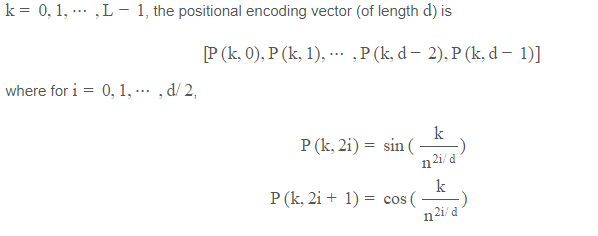



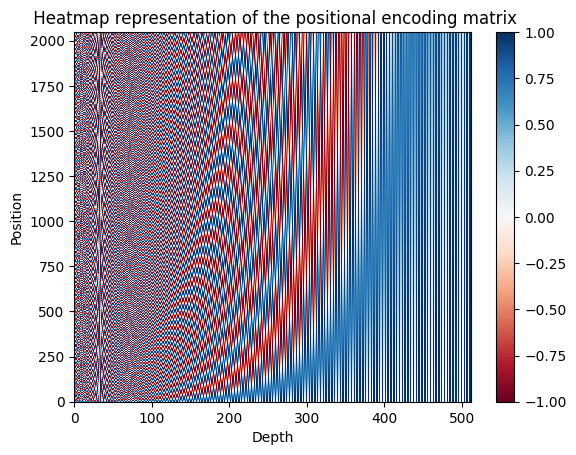

In [64]:

import pickle

import matplotlib.pyplot as plt
import numpy as np


def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P


# Plot the positional encoding matrix
pos_matrix = pos_enc_matrix(L=2048, d=512)
assert pos_matrix.shape == (2048, 512)       # length column vector 2048 , depth = 512
plt.pcolormesh(pos_matrix, cmap='RdBu')
plt.title(" Heatmap representation of the positional encoding matrix")
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

with open("posenc-2048-512.pickle", "wb") as fp:
    pickle.dump(pos_matrix, fp)

 Tested it out with L=2048
 and D = 512
 above. The output would be a
 matrix and also plot the encoding in a heatmap.

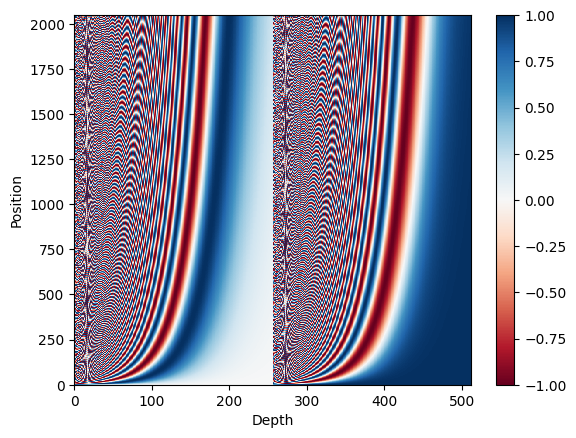

In [65]:

import pickle

import matplotlib.pyplot as plt
import numpy as np


with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Plot the positional encoding matrix, alternative way
plt.pcolormesh(np.hstack([pos_matrix[:, ::2], pos_matrix[:, 1::2]]), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()



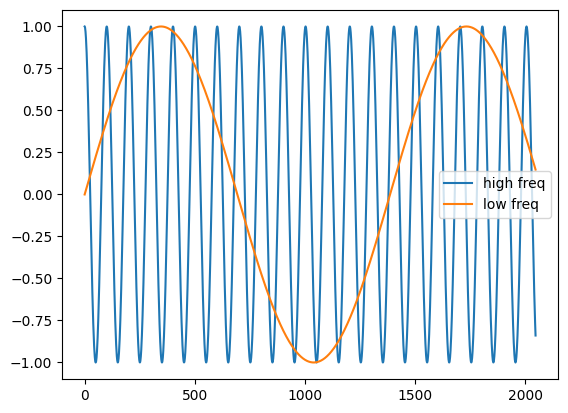

In [66]:
#To check that the different “depth” in the matrix represents a sine curve of different frequency.
# sine wave
plt.plot(pos_matrix[:, 155], label="high freq")
plt.plot(pos_matrix[:, 300], label="low freq")
plt.legend()
plt.show()

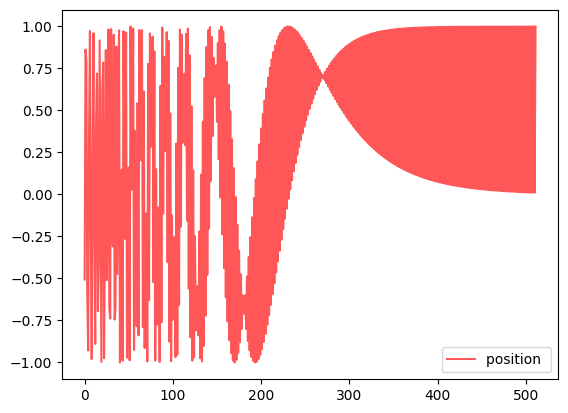

In [67]:
# Each individual “position” of the matrix, you see an interesting curve.

import pickle
import matplotlib.pyplot as plt

with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Plot two curves from different position
plt.plot(pos_matrix[100], alpha=0.66, color="red", label="position ")
plt.legend()
plt.show()

The encoding matrix is to compare two encoding vectors, to can tell how far apart their positions are. The dot-product of two normalized vectors is 1 if they are identical and drops quickly as they move apart. To known relationship.

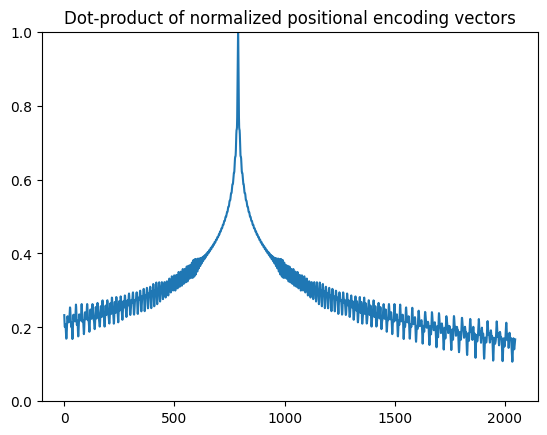

In [68]:

import pickle

import matplotlib.pyplot as plt
import numpy as np


with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Show the dot product between different normalized positional vectors
pos_matrix /= np.linalg.norm(pos_matrix, axis=1, keepdims=True)
p = pos_matrix[789]  # all vectors compare to vector at position 789
dots = pos_matrix @ p
plt.title("Dot-product of normalized positional encoding vectors")
plt.plot(dots)
plt.ylim([0, 1])
plt.show()

# POSITIONAL ENCODING LAYER
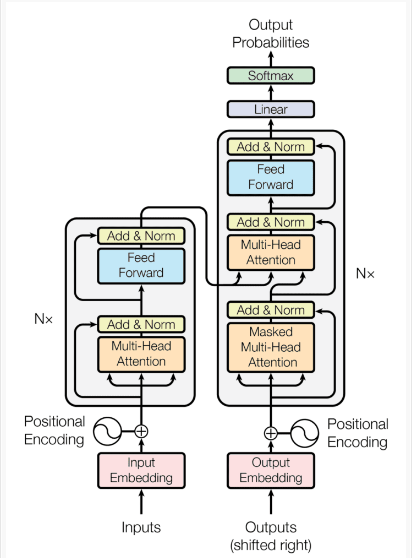

The positional encoding layer is at the entry point of a transformer model
The transformer model from the paper Attention Is All You Need

This layer is indeed combining an embedding layer with position encoding. The embedding layer creates word embeddings, namely, converting an integer token label from the vectorized sentence into a vector that can carry the meaning of the word. With the embedding,  can tell how close in meaning the two different words are.

The embedding output depends on the tokenized input sentence. But the positional encoding is a constant matrix as it depends only on the position. Hence to create a constant tensor for that at the time you created this layer. TensorFlow is smart enough to match the dimensions when you add the embedding output to the positional encoding matrix, in the call() function.

Two additional functions are defined in the layer above. The compute_mask() function is passed on to the embedding layer. This is needed to tell which positions of the output are padded. This will be used internally by Keras. The get_config() function is defined to remember all the config parameters of this layer. This is a standard practice in Keras so that you remember all the parameters you passed on to the constructor and return them in get_config(), so the model can be saved and loaded.

In [69]:

import numpy as np
import tensorflow as tf

def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

class PositionalEmbedding(tf.keras.layers.Layer):
    """Positional embedding layer. Assume tokenized input, transform into
    embedding and returns positional-encoded output."""
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Args:
            sequence_length: Input sequence length
            vocab_size: Input vocab size, for setting up embedding matrix
            embed_dim: Embedding vector size, for setting up embedding matrix
        """
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim     # d_model in paper
        # token embedding layer: Convert integer token to D-dim float vector
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )
        # positional embedding layer: a matrix of hard-coded sine values
        matrix = pos_enc_matrix(sequence_length, embed_dim)
        self.position_embeddings = tf.constant(matrix, dtype="float32")

    def call(self, inputs):
        """Input tokens convert into embedding vectors then superimposed
        with position vectors"""
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings

    # this layer is using an Embedding layer, which can take a mask

    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


In [70]:
vocab_size_en = 10000
seq_length = 20

# test the dataset                            # test data
for inputs, targets in train_ds.take(1):
    print(inputs["encoder_inputs"])
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask)

tf.Tensor(
[[  32   22 2077 ...    0    0    0]
 [   3  460  164 ...    0    0    0]
 [  99   13    4 ...    0    0    0]
 ...
 [  44   83  109 ...    0    0    0]
 [  27   33  181 ...    0    0    0]
 [  54    9   26 ...    0    0    0]], shape=(64, 20), dtype=int64)
(64, 20, 512)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 20), dtype=bool)


we see that the first tensor printed above is one batch (64 samples) of the vectorized input sentences, padded with zero to length 20. Each token is an integer but will be converted into an embedding of dimension 512. Hence the shape of en_emb above is (64, 20, 512).

The last tensor printed above is the mask used. This essentially matches the input where the position is not zero. When you compute the accuracy, you have to remember the padded locations should not be counted.


# Transformer buliding block


> The beyond the embedding and positional encoding, you have the encoder (left half) and decoder (right half of the figure). They share some similarities. Most notably, they have a multi-head attention block at the beginning and a feed forward block at the end.

It would be easier to create each building block as separate submodels and later combine them into a bigger model.

 To create the self-attention model. It is in the part of the diagram that is at the bottom of both encoder and decoder. A multi-head attention layer will take three inputs, namely, the key, the value, and the query. If all three inputs are the same, we call this multi-head attention layer self-attention. This submodel will have an add & norm layer with skip connection to normalize the output of the attention layer.





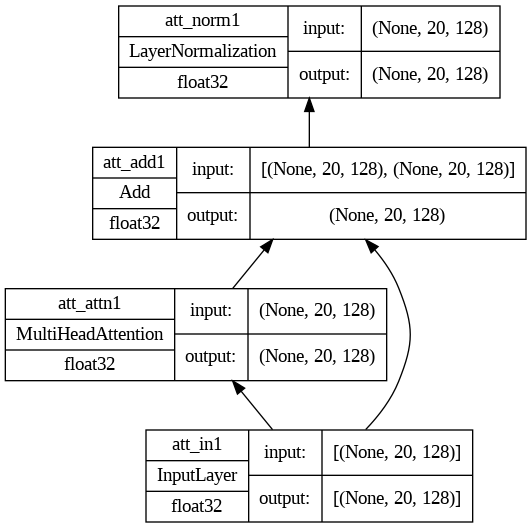

In [71]:

import tensorflow as tf

def self_attention(input_shape, prefix="att", mask=False, **kwargs):
    """Self-attention layers at transformer encoder and decoder. Assumes its
    input is the output from positional encoding layer.

    Args:
        prefix (str): The prefix added to the layer names
        masked (bool): whether to use causal mask. Should be False on encoder and
                       True on decoder. When True, a mask will be applied such that
                       each location only has access to the locations before it.
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
    add = tf.keras.layers.Add(name=f"{prefix}_add1")
    # functional API to connect input to output
    attout = attention(query=inputs, value=inputs, key=inputs,
                       use_causal_mask=mask)
    outputs = norm(add([inputs, attout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model

seq_length = 20
key_dim = 128
num_heads = 8
model = self_attention(input_shape=(seq_length, key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "self-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

In the decoder, you have a cross-attention model that takes input from the self-attention model as well as the encoder. In this case, the value and key are the output from the encoder whereas the query is the output from the self-attention model. At the high level, it is based on what the encoder understands about the context of the source sentence, and takes the partial sentence at the decoder’s input as the query (which can be empty), to predict how to complete the sentence. This is the only difference from the self-attention model

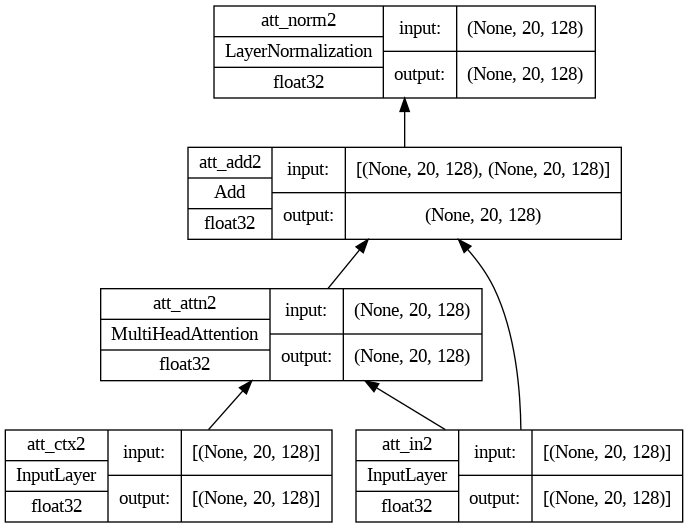

In [72]:
import tensorflow as tf

def cross_attention(input_shape, context_shape, prefix="att", **kwargs):
    """Cross-attention layers at transformer decoder. Assumes its
    input is the output from positional encoding layer at decoder
    and context is the final output from encoder.

    Args:
        prefix (str): The prefix added to the layer names
    """
    # create layers
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32',
                                    name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in2")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2")
    add = tf.keras.layers.Add(name=f"{prefix}_add2")
    # functional API to connect input to output
    attout = attention(query=inputs, value=context, key=context)
    outputs = norm(add([attout, inputs]))
    # create model and return
    model = tf.keras.Model(inputs=[(context, inputs)], outputs=outputs,
                           name=f"{prefix}_cross")
    return model

seq_length = 20
key_dim = 128
num_heads = 8

model = cross_attention(input_shape=(seq_length, key_dim),
                        context_shape=(seq_length, key_dim),
                        num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "cross-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

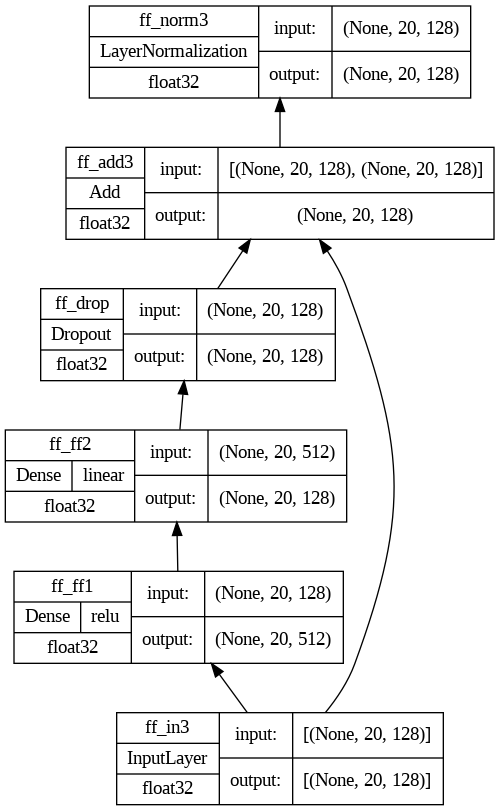

In [73]:
import tensorflow as tf
 # feed forward submodel
def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):
    """Feed-forward layers at transformer encoder and decoder. Assumes its
    input is the output from an attention layer with add & norm, the output
    is the output of one encoder or decoder block

    Args:
        model_dim (int): Output dimension of the feed-forward layer, which
                         is also the output dimension of the encoder/decoder
                         block
        ff_dim (int): Internal dimension of the feed-forward layer
        dropout (float): Dropout rate
        prefix (str): The prefix added to the layer names
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in3")
    dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
    dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")
    add = tf.keras.layers.Add(name=f"{prefix}_add3")
    # functional API to connect input to output
    ffout = drop(dense2(dense1(inputs)))
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")
    outputs = norm(add([inputs, ffout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
    return model

seq_length = 20
key_dim = 128
ff_dim = 512

model = feed_forward(input_shape=(seq_length, key_dim),
                     model_dim=key_dim, ff_dim=ff_dim)
tf.keras.utils.plot_model(model, "feedforward.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

# TRANSFORMER DECODER

---



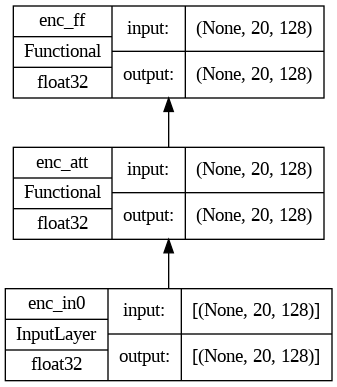

In [74]:
def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
    """One encoder unit. The input and output are in the same shape so we can
    daisy chain multiple encoder units into one larger encoder"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model


seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "encoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

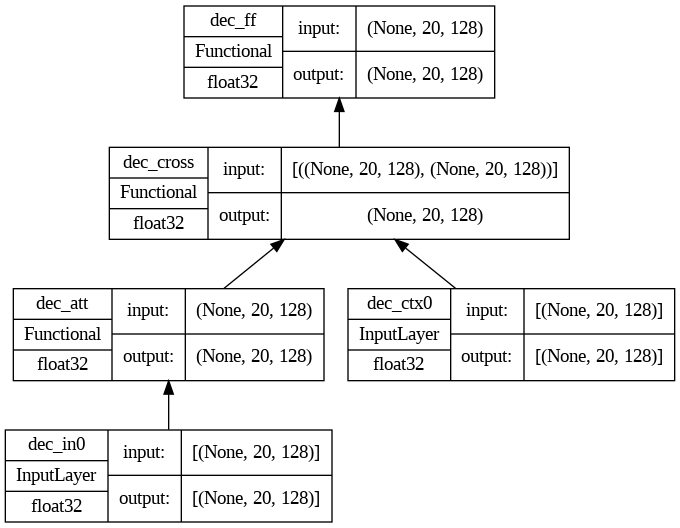

In [75]:
# DECODER SUBMODEL
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
    """One decoder unit. The input and output are in the same shape so we can
    daisy chain multiple decoder units into one larger decoder. The context
    vector is also assumed to be the same shape for convenience"""
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                    name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True,
                              prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                                 prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model


seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "decoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

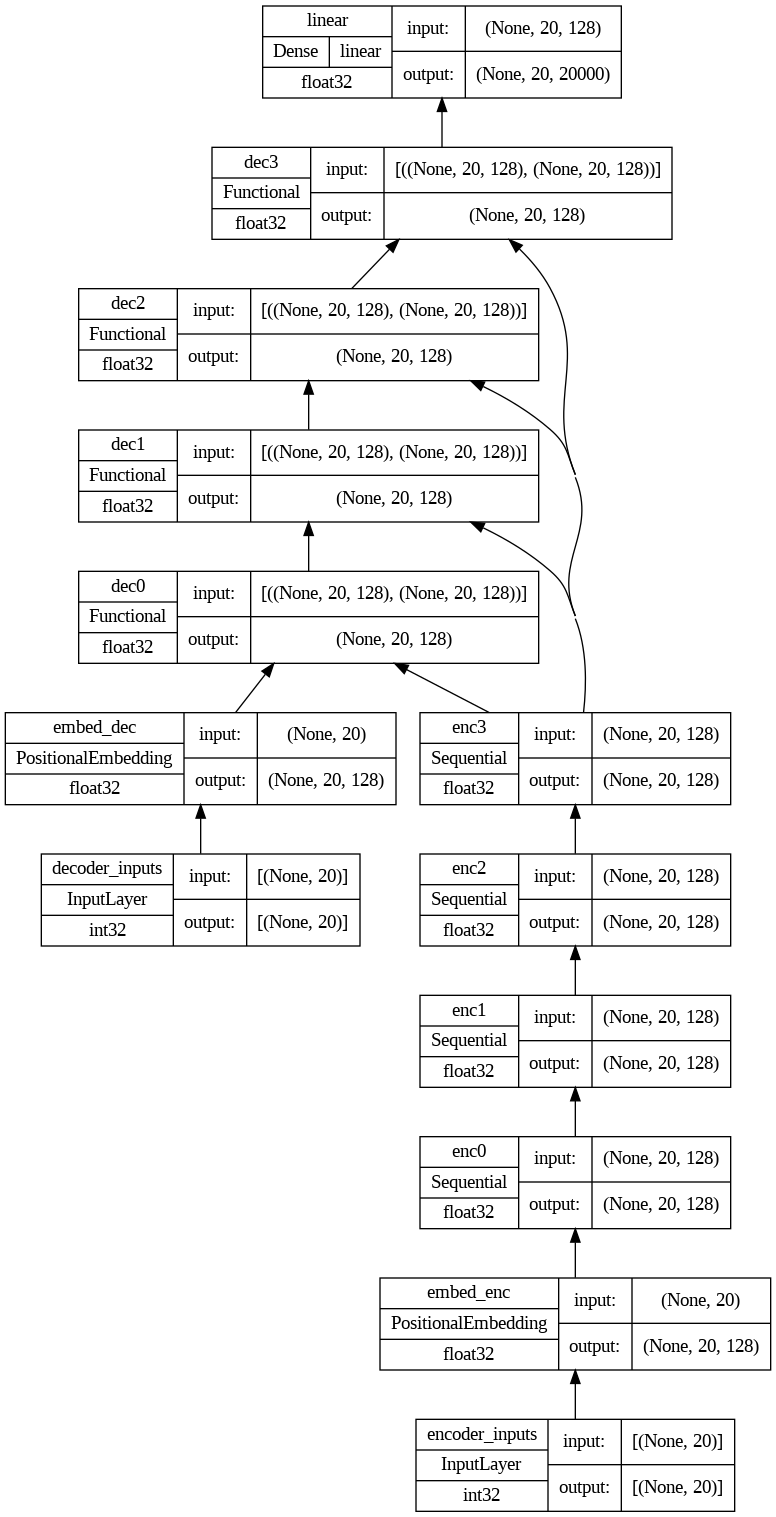

In [76]:
 # ENTIRE TRANSFORMER MODEL
 #Transformer with 4 layers in encoder and 4 layers in decoder
def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src,
                vocab_size_tgt, dropout=0.1, name="transformer"):
    embed_shape = (seq_len, key_dim)  # output shape of the positional embedding layer
    # set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="decoder_inputs")
    embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")
    encoders = [encoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")
    # build output
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])
    output = final(x2)
    # XXX keep this try-except block
    try:
        del output._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model


seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

# Prepare Transformer model for Training

According to the paper Attention Is All You Need, you are using Adam as the optimizer but with a custom learning rate schedule,

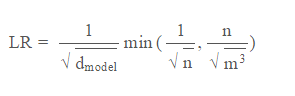

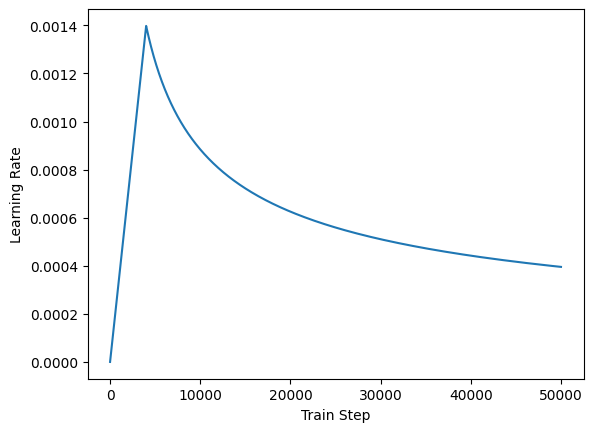

In [77]:

import matplotlib.pyplot as plt
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config

key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

The learning rate schedule is designed in such a way that it learns slowly at the beginning but accelerates as it learns. This helps because the model is totally random at the beginning, and cannot even trust the output much. But as you train the model enough, the result should be sufficiently sensible and thus can learn faster to help convergence.

In [80]:

def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

 To need to define the loss metric and accuracy metric for training. This model is special because you need to apply a mask to the output to calculate the loss and accuracy only on the non-padding elements. Borrow the implementation from TensorFlow’s tutorial Neural machine translation with a Transformer and Keras

In [82]:

vocab_size_en = 10000
vocab_size_fr = 20000
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 embed_enc (PositionalEmbedding  (None, 20, 128)     1280000     ['encoder_inputs[0][0]']         
 )                                                                                                
                                                                                                  
 enc0 (Sequential)              (None, 20, 128)      659712      ['embed_enc[0][0]']              
                                                                                                  
 enc1 (Sequential)              (None, 20, 128)      659712      ['enc0[0][0]']         

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Create and train the model
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the trained model
model.save("eng-fra-transformer.h5")

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

Epoch 1/20
 243/1828 [==>...........................] - ETA: 54:30 - loss: 9.2383 - masked_accuracy: 0.0966

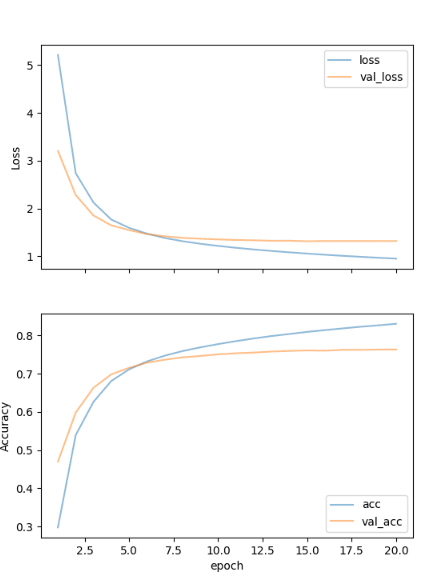

# Inference transformer model

In [ ]:
# Load the trained model
custom_objects = {"PositionalEmbedding": PositionalEmbedding,
                  "CustomSchedule": CustomSchedule,
                  "masked_loss": masked_loss,
                  "masked_accuracy": masked_accuracy}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model("eng-fra-transformer.h5")

# training parameters used
seq_len = 20
vocab_size_en = 10000
vocab_size_fr = 20000

def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(fra_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = fra_vectorizer([" ".join(output_sentence)])
        assert vector.shape == (1, seq_len+1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_len)
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_len, vocab_size_fr)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

test_count = 20
for n in range(test_count):
    english_sentence, french_sentence = random.choice(test_pairs)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {french_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

In [ ]:
Test 2:
it rained for three days .
== [start] il a plu pendant trois jours . [end]
-> [start] il a plu pendant trois jours . [end]

Test 3:
two people say they heard a gunshot .
== [start] deux personnes disent qu'elles ont entendu une détonation . [end]
-> [start] deux personnes disent qu'ils ont entendu un coup de feu . [end]

Test 4:
i'm not dead yet .
== [start] je ne suis pas encore mort . [end]
-> [start] je ne suis pas encore mort . [end]

Test 5:
i want us to get back together .
== [start] je veux que nous nous remettions ensemble . [end]
-> [start] je veux que nous nous [UNK] ensemble . [end]